<a href="https://colab.research.google.com/github/sjeena0722/3-min-pytorch/blob/main/GAN%EC%9C%BC%EB%A1%9C_%EC%83%88%EB%A1%9C%EC%9A%B4_%ED%8C%A8%EC%85%98%EC%95%84%EC%9D%B4%ED%85%9C_%EC%83%9D%EC%84%B1%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

EPOCHS 과 BATCH_SIZE 등 학습에 필요한 하이퍼 파라미터 들을 설정해 줍니다.

In [ ]:
# 하이퍼파라미터
EPOCHS = 500
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


학습에 필요한 데이터셋을 로딩합니다.

In [ ]:
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    './.data',
    train=True,
    download=True,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
    ])
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



생성자는 64차원의 랜덤한 텐서를 입력받아 이에 행렬곱(Linear)과 활성화 함수(ReLU, Tanh) 연산을 실행합니다. 생성자의 결과값은 784차원, 즉 Fashion MNIST 속의 이미지와 같은 차원의 텐서입니다.

In [ ]:
# 생성자 (Generator)
G = nn.Sequential(
        nn.Linear(64, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 784),
        nn.Tanh())

판별자는 784차원의 텐서를 입력받습니다. 판별자 역시 입력된 데이터에 행렬곱과 활성화 함수를 실행시키지만, 생성자와 달리 판별자의 결과값은 입력받은 텐서가 진짜인지 구분하는 예측값입니다.

In [ ]:
# 판별자 (Discriminator)
D = nn.Sequential(
        nn.Linear(784, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 1),
        nn.Sigmoid())

생성자와 판별자 학습에 쓰일 오차 함수와 최적화 알고리즘도 정의해 줍니다.

In [ ]:
# 모델의 가중치를 지정한 장치로 보내기
D = D.to(DEVICE)
G = G.to(DEVICE)

# 이진 크로스 엔트로피 (Binary cross entropy) 오차 함수와
# 생성자와 판별자를 최적화할 Adam 모듈
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

모델 학습에 필요한 준비는 끝났습니다. 그럼 본격적으로 GAN을 학습시키는 loop을 만들어 보겠습니다.

In [ ]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)
        
        # 판별자가 진짜 이미지를 진짜로 인식하는 오차를 예산
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # 무작위 텐서로 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
        fake_images = G(z)
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차를 계산
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자의 오차 계산
        d_loss = d_loss_real + d_loss_fake

        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자가 판별자를 속였는지에 대한 오차를 계산
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)
        
        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    # 학습 진행 알아보기
    print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
          .format(epoch, EPOCHS, d_loss.item(), g_loss.item(), 
                  real_score.mean().item(), fake_score.mean().item()))

Epoch [0/500], d_loss: 0.0306, g_loss: 5.1240, D(x): 0.99, D(G(z)): 0.02
Epoch [1/500], d_loss: 0.0508, g_loss: 5.2864, D(x): 0.99, D(G(z)): 0.01
Epoch [2/500], d_loss: 0.1100, g_loss: 6.7395, D(x): 0.97, D(G(z)): 0.01
Epoch [3/500], d_loss: 0.0171, g_loss: 6.1577, D(x): 1.00, D(G(z)): 0.01
Epoch [4/500], d_loss: 0.0679, g_loss: 6.5320, D(x): 0.98, D(G(z)): 0.02
Epoch [5/500], d_loss: 0.1123, g_loss: 7.8730, D(x): 0.96, D(G(z)): 0.01
Epoch [6/500], d_loss: 0.1644, g_loss: 6.1866, D(x): 0.99, D(G(z)): 0.06
Epoch [7/500], d_loss: 0.2662, g_loss: 5.9547, D(x): 0.96, D(G(z)): 0.01
Epoch [8/500], d_loss: 0.1298, g_loss: 6.1714, D(x): 0.97, D(G(z)): 0.05
Epoch [9/500], d_loss: 0.1096, g_loss: 5.0827, D(x): 0.98, D(G(z)): 0.08
Epoch [10/500], d_loss: 0.2883, g_loss: 5.5779, D(x): 0.90, D(G(z)): 0.03
Epoch [11/500], d_loss: 0.2688, g_loss: 4.4293, D(x): 0.95, D(G(z)): 0.07
Epoch [12/500], d_loss: 0.3719, g_loss: 5.1574, D(x): 0.88, D(G(z)): 0.03
Epoch [13/500], d_loss: 0.2536, g_loss: 4.9446, 

학습이 끝난 생성자의 결과물을 한번 확인해 보겠습니다.

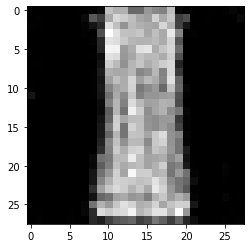

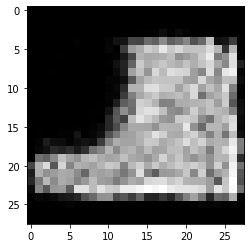

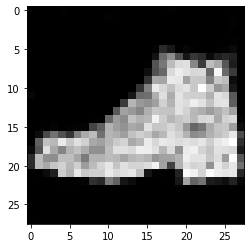

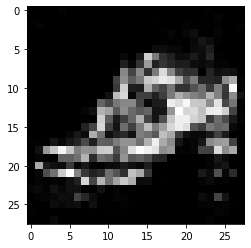

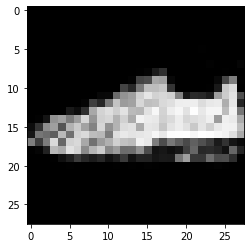

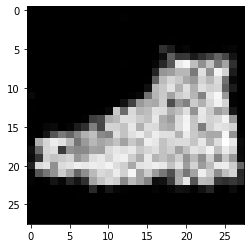

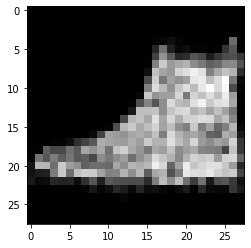

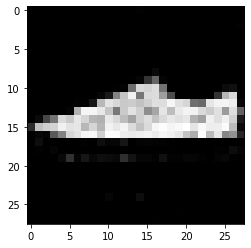

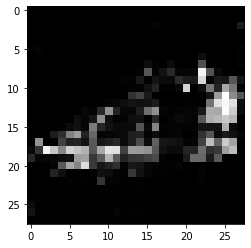

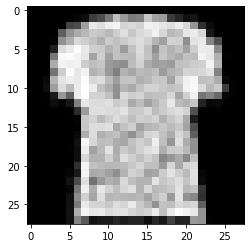

In [ ]:
z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
fake_images = G(z)
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28, 28))
    plt.imshow(fake_images_img, cmap = 'gray')
    plt.show()